In [1]:
import splat
import wisps
import matplotlib.pyplot as plt
from wisps.data_analysis import selection_criteria as sel_crt
from wisps.simulations import selection_function as slf
import numpy as np
import pandas as pd

import numba
import matplotlib as mpl

mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

%matplotlib inline
#%%capture  output
import splat
import itertools
from tqdm import tqdm
from numba import cuda

In [2]:
sf=pd.read_pickle(wisps.OUTPUT_FILES+'/selection_function.pkl') #the simulated spectral data
rf=pd.read_pickle(wisps.OUTPUT_FILES+'/random_forest_classifier.pkl') #the classifier 
min_max_scaler= pd.read_pickle(wisps.OUTPUT_FILES+'/min_max_scaler.pkl')#the min max scaler used to transform the data
indices_to_use= pd.read_pickle(wisps.OUTPUT_FILES+'/best_indices_to_use.pkl')

In [3]:
mask=sf.data.snr1.apply(np.log10).between(-1, 3.5)

In [4]:
simulated_data=sf.data[mask]

In [5]:
def get_weight(spt):
    number=len(sf.data[sf.data.spt==spt])
    return 1/(number)

In [6]:
simulated_data['weight']=simulated_data.spt.apply(get_weight)

In [7]:
sampled_data=simulated_data.sample(n=10000, weights='weight').reset_index(drop=True)

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


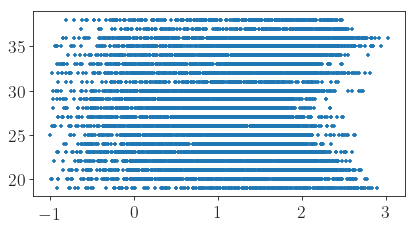

In [8]:
plt.scatter(sampled_data.snr1.apply(np.log10), sampled_data.spt, marker='+', s=15)

In [9]:
#selection criteria
slc_crts=sel_crt.crts_from_file()

In [10]:
rf_features=['CH_4/H-Cont', 'CH_4/H_2O-1', 'CH_4/H_2O-2', 'CH_4/J-Cont',
       'H-cont/H_2O-1', 'H-cont/H_2O-2', 'H-cont/J-Cont', 'H_2O-1/J-Cont',
       'H_2O-2/H_2O-1', 'H_2O-2/J-Cont',  'spex_chi', 'snr2',
       'line_chi', 'f_test', 'x']
#features used by the classifier

#### Define a bunch of selection processes

In [11]:
#define a number of selectors 
#each selection should a column of zeros and ones corresponding
#to where objects were selected
#each selector input is the simulated df
def select_by_indices(df):
    #use spectral indices
    good_indices=[slc_crts[k] for k in indices_to_use.keys()]
    cands=[]
    for idx, k in zip(good_indices, indices_to_use.keys()):
        spt_range=indices_to_use[k][0]
        print (spt_range)
        bs=idx.shapes
        bx=[x for x in bs if x.shape_name==spt_range][0]
        df_to_use=wisps.Annotator.reformat_table(df[[idx.xkey, idx.ykey]])
        selec_indx_array=bx.select(df_to_use).index
        ls=df.iloc[selec_indx_array].Names
        cands.append(ls)
    
    merged = np.array(list(itertools.chain(*cands)))
    final_cands=np.unique(merged.flatten())
    return (df.Names.isin(final_cands))

def select_by_f_test(df):
    return df['f_test']>.5
    
def select_by_random_forest(df):
    #use the classification given by my rf classifier
    prblm_feats=['line_chi', 'spex_chi', 'H_2O-2/J-Cont', 'H-cont/J-Cont', 'H_2O-1/J-Cont', 'H-cont/H_2O-1', 'snr2', 'x']
    
    #apply logs to problematic features the same way I did on my classification
    df[prblm_feats]=df[prblm_feats].applymap(np.log10).replace(np.inf, np.nan).replace(-np.inf, np.nan).replace(np.nan, -999999.9)
    
    #scale the features 
    x=df[rf_features].replace(-np.inf, np.nan).replace(np.nan,  -999999.9).values
    
    #check for 15 columns
    print (x.shape)
    pred_set=min_max_scaler.transform(x)
    labels=rf.predict(pred_set)
    
    #return the predictions
    return labels

def select_by_snr(df):
    #use snr cutoff
    pass


#@numba.jit(parallel=True, cache=True)
def probability_of_selection(vals, method='f_test_label'):
    """
    probablity of selection for a given snr and spt
    """
    spt, snr=vals
    #self.data['spt']=self.data.spt.apply(splat.typeToNum)
    floor=np.floor(spt)
    floor2=np.log10(np.floor(snr))
    if floor2 < np.log10(3.):
        return 0.
    else:
        return np.nanmean(df[method][(df.spt==floor) &(df.snr1.apply(np.log10).between(floor2, floor2+.3))])

@numba.vectorize(['float32(float32, float32)','float64(float64, float64)'])
def selection_function(spt, snr):
    return  probability_of_selection((spt, snr))

#### Add missing features to the data

In [12]:
@numba.vectorize
def proper_motion(vt, d):
    """
    mu in arcsec/y
    d in pc
    vt in
    """
    return vt/(4.74*d)

@numba.vectorize("float64(float64)")
def probability_of_detection_smearing(mu):
    if mu*3>0.1:
        return 1.
    else:
        return 0.0

In [13]:
#probability_of_detection_smearing(np.nan)

In [14]:
sampled_data=sampled_data.rename(columns={"f":"f_test"})

In [15]:
sampled_data['x']=sampled_data.spex_chi/sampled_data.line_chi

In [16]:
df=sampled_data

In [17]:
df['f_test_label']=select_by_f_test(df).apply(int)

In [18]:
df['rf_label']=select_by_random_forest(wisps.Annotator.reformat_table(df))

(10000, 15)


In [19]:
df['index_label']=select_by_indices(df).apply(int)

L0-L5
L5-T0
M7-L0
T0-T5
T5-T9
subdwarfs


In [20]:
df['idx_ft_label']=np.logical_and(df['index_label'].apply(bool), df['f_test_label'].apply(bool) ).apply(int)

In [21]:
df['idx_ml_label']=np.logical_and(df['index_label'].apply(bool), df['rf_label'].apply(bool) ).apply(int)

In [22]:
import seaborn as sns 
cmap=sns.light_palette((210, 90, 60), input="husl", as_cmap=True)

In [23]:
df['logsnr']=df['snr2'].apply(np.log10)

In [24]:
from matplotlib.ticker import MultipleLocator

In [25]:
df2=pd.DataFrame()
snrs=df.snr1.values
spts=df.spt.values
df2['snr']=snrs
df2['spt']=spts
df2['f_test_label']=selection_function(spts, snrs)
df2['rf_label']=df2[['spt', 'snr']].apply(probability_of_selection, axis=1, method='rf_label')
df2['index_label']=df2[['spt', 'snr']].apply(probability_of_selection, axis=1, method='index_label')

In [26]:
df2['idx_ft_label']=df2[['spt', 'snr']].apply(probability_of_selection, axis=1, method='idx_ft_label')

In [27]:
df2['logsnr']=df2.snr.apply(np.log10)

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


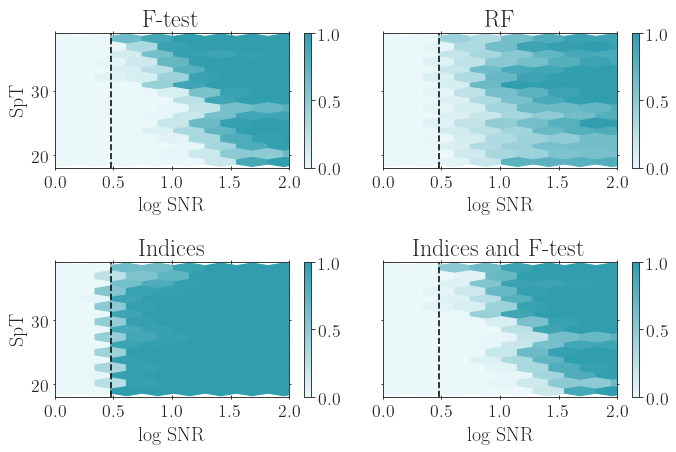

In [28]:
fig, ax=plt.subplots(ncols=2, nrows=2, figsize=(6*1.5, 4*1.5), sharex=False, sharey=True)
df2.plot.hexbin(x='logsnr', y='spt', C='f_test_label', reduce_C_function=np.nanmean, gridsize=15, cmap=cmap, ax=ax[0][0])
df2.plot.hexbin(x='logsnr', y='spt', C='rf_label', reduce_C_function=np.nanmean, gridsize=15, cmap=cmap, ax=ax[0][1])

df2.plot.hexbin(x='logsnr', y='spt', C='index_label', reduce_C_function=np.nanmean, gridsize=15, cmap=cmap, ax=ax[1][0])
df2.plot.hexbin(x='logsnr', y='spt', C='idx_ft_label', reduce_C_function=np.nanmean, gridsize=15, cmap=cmap, ax=ax[1][1])

#ax[0][0].scatter( sf.data.snr1.apply(np.log10), sf.data.spt, marker='+', color='#111111', alpha=.05)


ax[0][0].set_title('F-test')
ax[0][1].set_title('RF')
ax[1][0].set_title('Indices')
ax[1][1].set_title('Indices and F-test')

for a in np.concatenate(ax):
    a.set_xlabel('log SNR')
    a.set_ylabel('SpT')
    a.axvline(np.log10(3), linestyle='--', color='#111111')
    #a.axvline(np.log10(10), linestyle='--', color='#111111', alpha=0.5)
    #a.grid()
    a.yaxis.set_ticks_position('both')
    a.xaxis.set_ticks_position('both')
    #a.set_yticks(np.arange(20, 40, 1), minor=True)
    a.tick_params(which='major',direction='inout')
    a.tick_params(which='minor', direction='in')
    ml = MultipleLocator(1.)
    a.yaxis.set_minor_locator(ml)
    
    a.set_xlim([0., 2.])
    
plt.tight_layout()

#fig.axes[3].set_title(r'$\mathcal{S}$')
#fig.axes[2].set_title(r'$\mathcal{S}$')

plt.savefig(wisps.OUTPUT_FIGURES+'/selection_function_samples.pdf', bbox_inches='tight', dpi=200)

In [29]:
#ranges=np.arange(20, 40), np.arange(20, 40)]
for x in np.arange(20, 40):
    print (x, len(sf.data[sf.data.spt.between(x, x+1)]))

20 8400
21 8700
22 6300
23 4900
24 4700
25 8200
26 21600
27 17900
28 4400
29 5200
30 3300
31 2300
32 3600
33 3800
34 5600
35 8000
36 4500
37 700
38 300
39 0


### Apply these to the simulations

Assign distances, see which objects get selected

In [30]:
import wisps.simulations as wispsim

In [31]:
#selection_function(20.0, 21.)

In [32]:
LF=wisps.LUMINOSITY_FUCTION
LFDES=wisps.DES_LUMINOSITY_FUCTION
MAGLIMITS=wisps.MAG_LIMITS
PNTS=wisps.OBSERVED_POINTINGS
CANDS=wisps.datasets['candidates']
DIST_DATAFRAME=pd.DataFrame.from_records([x.samples for x in wisps.OBSERVED_POINTINGS])
SIMULATED_DIST=wispsim.simulate_spts()

In [33]:
spgrid=np.arange(20., 37.)

In [34]:
vols=[]
for spt in spgrid:
    vm=[]
    for pntg in PNTS:
        vm.append(pntg.volume[spt])
    vols.append(vm)

In [35]:
vols=np.array(vols)

In [36]:
import astropy.units as u

In [37]:
volumes=np.nansum(vols, axis=1)*(4.1*(u.arcmin**2).to(u.radian**2))

In [38]:
def drop_nan(x):
    x=np.array(x)
    return x[(~np.isnan(x)) & (~np.isinf(x)) ]

In [39]:
def interpolated_lf(spts, lumin):
    f = interp1d(spts, lumin)
    return f(spgrid)

In [40]:
import random

In [41]:
def compute_effective_numbers(spts,spgrid):
    ##given a distribution of masses, ages, teffss
    ## based on my polynomial relations and my own selection function
    @numba.vectorize("float64(float64)")
    def match_dist_to_spt(spt):
        """
        one to one matching between distance and spt
        to avoid all sorts of interpolations or binning
        """
        #round spt to nearets
        spt_r=np.floor(spt)
        if spt_r in DIST_DATAFRAME.columns:
            ds=np.concatenate(DIST_DATAFRAME[spt_r])
            rdn=random.choice(ds)
        else:
            rdn=np.nan
        
        return rdn

        
    #polynomial relations
    rels=wisps.POLYNOMIAL_RELATIONS
    #effective volumes
    #assign distances
    dists_for_spts=match_dist_to_spt(spts)
    #compute magnitudes absolute mags
    f110s= rels['sp_F110W'](spts)
    f140s= rels['sp_F140W'](spts)
    f160s= rels['sp_F160W'](spts)
    #compute apparent magnitudes
    appf140s=f140s+5*np.log10(dists_for_spts/10.0)
    #compute snr based on my relations
    #only use F140W for SNRJS
    #offset them by the scatter in the relation
    f140_snrj_scatter=rels['sigma_log_f140']
    snrjs=10**np.random.normal(np.array(rels['snr_F140W'](appf140s)), f140_snrj_scatter)
    #apply the selection function (this is the slow part)
    sl= selection_function(spts, snrjs)
    #the probabliy of smearing
    vts=np.random.uniform(0, 100, len(dists_for_spts))
    mus=proper_motion(vts, dists_for_spts)
    smearing_p=probability_of_detection_smearing(mus)

    #group these by spt
    df=pd.DataFrame()
    df['spt']=spts
    df['ps_sme']=smearing_p*sl #selection probability including proper motion
    df['ps']=sl
    df['appF110']=appf140s
    df['snr']=snrjs
    #round the spt for groupings
    df.spt=df.spt.apply(round)
    
    #make selection cuts 
    df_cut=df.drop(df[(df.appF110>MAGLIMITS['wisps']['F110W'][0]) & (df.appF110> MAGLIMITS['wisps']['F110W'][1]) & (df.snr > 3.0)].index)

    #group by spt and sum
    phi0=[]
    phi0_spts=[]

    for g in df_cut.groupby('spt'):
        phi0_spts.append(g[0])
        phi0.append(np.nansum(g[1].ps_sme))

    idx=[i for i, x in enumerate(phi0_spts) if x in spgrid]

    #finally some luminosity function
    phi=np.array(phi0)[idx]
    #return all the data

    return f110s, f140s, f160s, dists_for_spts, appf140s, snrjs, phi

from scipy.interpolate import interp1d
def interpolated_lf(spts, lumin):
    f = interp1d(spts, lumin)
    return f(spgrid)


## compare simulations

In [42]:
NORM=SIMULATED_DIST['norm']

In [43]:
#import numpy as np

In [44]:
#np.random.choice(np.arange(1000), 10)

In [45]:
f110s=[]
f140s=[]
f160s=[]
dists=[]
snrjs=[]
phis=[]
appf110s=[]
for idx in tqdm(np.arange(3)):
    spts=drop_nan(SIMULATED_DIST['spts'][idx][:,0])
    f110, f140, f160, dists_for_spts, appf110, snrj, phi=compute_effective_numbers(spts,spgrid)
    f110s.append(f110)
    f140s.append(f140)
    f160s.append(f160)
    dists.append(dists_for_spts)
    snrjs.append(snrj)

    phis.append(phi)
    appf110s.append(appf110)

100%|██████████| 3/3 [24:51<00:00, 517.17s/it]


In [46]:
from matplotlib.ticker import MultipleLocator
import seaborn as sns
ml1 = MultipleLocator(1.)
ml2 = MultipleLocator(10.)
cmap = sns.cubehelix_palette(reverse=True, as_cmap=True)

In [47]:
betas=SIMULATED_DIST['betas']

In [48]:
colors=cmap(betas/10.0)

In [49]:
#bin in orders of 5 spts
def bin_by_spt_bin(sp_types, number):
    ranges=[[20, 25], [25, 30], [30, 35], [35, 40]]
    numbers=[]
    for r in ranges:
        idx= np.logical_and((r[0]<=sp_types), (r[1]>sp_types))
        numbers.append(np.nansum(number[idx]))
    return numbers

In [50]:
spgrid2=[ 'L0-L5', 'L5-T0', 'T0-T5', 'T5-Y0']

In [51]:
wisps.MAG_LIMITS

{'wisps': {'F110W': [22.0, 18.0],
  'F140W': [21.5, 16.0],
  'F160W': [21.5, 16.0]},
 'hst3d': {'F140W': [22.5, 16.0], 'F160W': [22.5, 16.0]}}

In [52]:
def stay_within_limits(row):
    #print (row)
    flag=True
    if row.survey.lower()=='wisp':
        if (row.F110>wisps.MAG_LIMITS['wisps']['F110W'][0] or row.F110<wisps.MAG_LIMITS['wisps']['F110W'][1]):
            flag=False
        if np.isnan(row.F110):
            flag=True
    if row.survey.lower()=='hst3d':

        if (row.F140>wisps.MAG_LIMITS['hst3d']['F140W'][0] or row.F140<wisps.MAG_LIMITS['hst3d']['F140W'][1]):
            flag=False
        if np.isnan(row.F140):
            flag=True
    if splat.typeToNum(row.spt)<=19.:
        flag=False
            
    return flag

In [53]:
cands_df=wisps.datasets['stars'][wisps.datasets['stars'].grism_id.isin(wisps.datasets['candidates'].grism_id)].reset_index(drop=True)

In [54]:
cands_df=wisps.Annotator.reformat_table(cands_df[['survey', 'spt', 'F110', 'F160', 'F140']])

In [55]:
cdf_to_use=cands_df[cands_df.apply(stay_within_limits, axis=1)]

In [56]:
#cdf_to_use.spt.apply(splat.typeToNum).values

In [57]:
#sptsobs=wisps.datasets['candidates'].spt.apply(splat.typeToNum).values
nobs, j =np.histogram(cdf_to_use.spt.apply(splat.typeToNum).values, bins=len(spgrid))

In [58]:
his, edges=np.histogram(drop_nan(SIMULATED_DIST['spts'][idx][:,0]), bins=np.arange(20, 38))

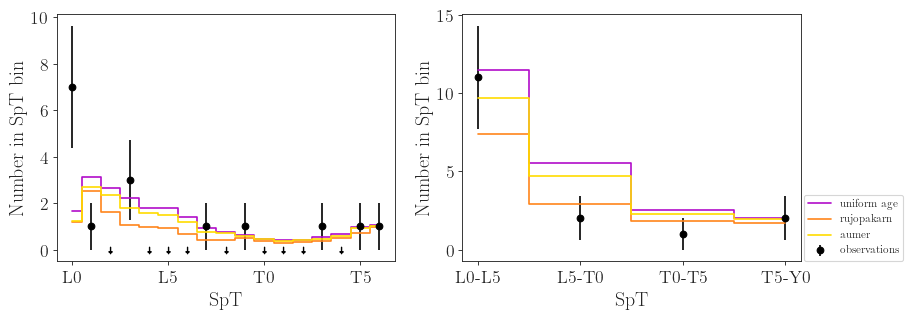

In [71]:
fig, (ax, ax1)=plt.subplots(ncols=2, figsize=(12, 4))

for x, y in zip(spgrid,nobs):
    if y>0:
        ax.errorbar(x,y, yerr=np.sqrt(y), label='observations',fmt='o', color='k')
    if y==0:
        ax.plot(x, y, linestyle='none', marker=r'$\downarrow$',   label='observations', color='k')


ax.step(spgrid, phis[0]*volumes*NORM,   color='#B10DC9',  where='mid', label='uniform age')
ax.step(spgrid, phis[1]*volumes*NORM,   color='#FF851B',  where='mid',  label='rujopakarn')
ax.step(spgrid, phis[2]*volumes*NORM,  color='#FFDC00',  where='mid',  label='aumer')
#ax.step(spgrid, interpolated_lf(LFDES.spts.values, LFDES.lf.values)*volumes*NORM, where='mid')


#ax1.step(spgrid2,bin_by_spt_bin(spgrid, his*volumes*NORM),  where='mid',)


ax1.errorbar(spgrid2,bin_by_spt_bin(spgrid,nobs),yerr=np.sqrt(bin_by_spt_bin(spgrid,nobs)), label='observations',fmt='o', color='k')

ax1.step(spgrid2, bin_by_spt_bin(spgrid, phis[0]*volumes*NORM),  color='#B10DC9',  where='mid', label='uniform age')
ax1.step(spgrid2, bin_by_spt_bin(spgrid, phis[1]*volumes*NORM), color='#FF851B',  where='mid',  label='rujopakarn')
ax1.step(spgrid2, bin_by_spt_bin(spgrid, phis[2]*volumes*NORM),color='#FFDC00',  where='mid',  label='aumer')

#for bidx in range(0, len(betas)):
#    ax.step(spgrid, phis[bidx+3]*volumes*NORM,   alpha=0.3,where='mid',  color=colors[bidx],
#               label=r'$\beta$ = {}'.format(round(betas[bidx], 2)), linestyle='--')
#    
#    
#    ax1.step(spgrid2, np.array(bin_by_spt_bin(spgrid, phis[bidx+3]*volumes*NORM)), 
#               where='mid',  color=colors[bidx],alpha=0.3,
#               label=r'$\beta$ = {}'.format(round(betas[bidx], 2)), linestyle='--')
#    
#    ax.xaxis.set_minor_locator(ml1)
#    ax1.yaxis.set_minor_locator(ml2)
    
ax1.legend( fontsize = 10., loc=(1.01, 0.))


ax.set_ylabel('Number in SpT bin')
ax1.set_ylabel('Number in SpT bin')
ax.set_xlabel('SpT')
ax1.set_xlabel('SpT')

ax.set_xticklabels(['M9','L0', 'L5', 'T0', 'T5'])
plt.savefig(wisps.OUTPUT_FIGURES+'/oberved_numbers.pdf', bbox_inches='tight')


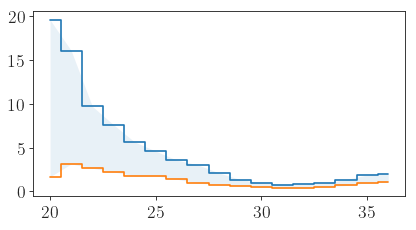

In [60]:
exp0= his*volumes*NORM
exp1=phis[0]*volumes*NORM
diff=exp0-exp1
plt.step(spgrid, exp0,  where='mid',)
plt.step(spgrid, exp1, where='mid',)
#plt.step(spgrid, diff, where='mid',)
plt.fill_between(spgrid, exp1, exp1+diff, alpha=0.1 )


In [61]:
np.nansum(phi*volumes*NORM)

18.593134525089273

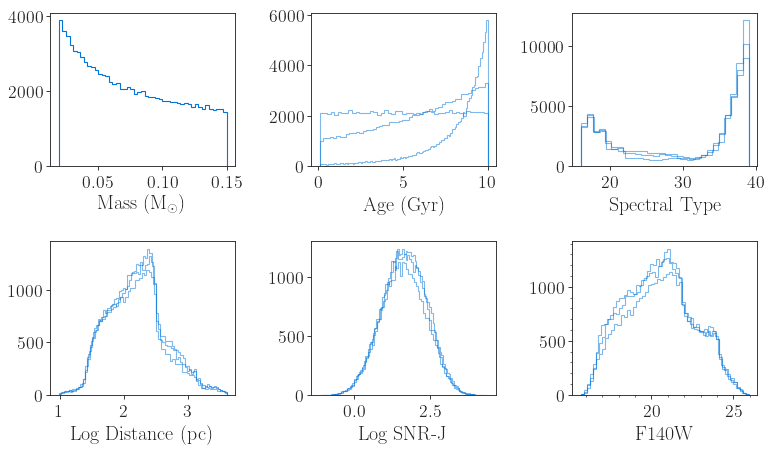

In [62]:
fig, ax=plt.subplots(ncols=3, nrows=2, figsize=(10, 6))

h= ax[0][0].hist(SIMULATED_DIST['mass'],  histtype='step', bins='auto', color='#0074D9')
for idx in np.arange(3):
    spts=drop_nan(SIMULATED_DIST['spts'][idx][:,0])
    ages=drop_nan(SIMULATED_DIST['ages'][idx])
    
    h=ax[1][0].hist(drop_nan(np.log10((np.array(dists)[idx]))), bins='auto', histtype='step', color='#0074D9', alpha=0.5)
    h=ax[1][1].hist(drop_nan(np.log10((np.array(snrjs)[idx]))), bins='auto', histtype='step', color='#0074D9', alpha=0.5)
    h=ax[1][2].hist(drop_nan((np.array(appf110s)[idx])), bins='auto', histtype='step', color='#0074D9', alpha=0.5)
    
    h=ax[0][2].hist(spts,  histtype='step', bins='auto', color='#0074D9', alpha=0.5)
    h=ax[0][1].hist(ages,  histtype='step', bins='auto', color='#0074D9', alpha=0.5)

ax[0][0].set_xlabel(r'Mass (M$_\odot$)')
ax[0][2].set_xlabel('Spectral Type')
ax[0][1].set_xlabel('Age (Gyr)')

ax[1][0].set_xlabel('Log Distance (pc)')
ax[1][1].set_xlabel('Log SNR-J')
ax[1][2].set_xlabel('F140W')

plt.minorticks_on()
plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/simulations_dists.pdf', bbox_inches='tight')

In [63]:
sim_vs=pd.DataFrame()

In [64]:
sim_vs['spt']=[splat.typeToNum(x).replace('.0', '') for x in spgrid]
sim_vs['volume']=np.round(volumes)
sim_vs['Number ex1']=np.round(his*volumes*NORM, 1)
sim_vs['Number ex']=np.round(volumes*NORM*phis[0], 1)
sim_vs['Number obs']=nobs

In [65]:
sim_vs.to_latex(wisps.LIBRARIES+'/expectations.tex', index=False, na_rep=' ')

In [66]:
sim_vs

,spt,volume,Number ex1,Number ex,Number obs
0,L0,13399.0,19.6,1.7,7
1,L1,10935.0,16.1,3.1,1
2,L2,8859.0,9.7,2.7,0
3,L3,7177.0,7.6,2.2,3
4,L4,5840.0,5.7,1.8,0
5,L5,4753.0,4.6,1.8,0
6,L6,3828.0,3.6,1.4,0
7,L7,3025.0,3.0,0.9,1
8,L8,2346.0,2.1,0.8,0
9,L9,1806.0,1.4,0.6,1


In [74]:
@numba.vectorize("float64(float64)")
def probability_of_detection_smearing(mu):
    if mu*3>0.1:
        return 1.
    else:
        return 0.0

In [75]:
ds=drop_nan(np.concatenate(DIST_DATAFRAME[21].values))
vts=np.random.uniform(1, 100, len(ds))
mus= proper_motion(vts, ds)
prob=probability_of_detection_smearing(mus)

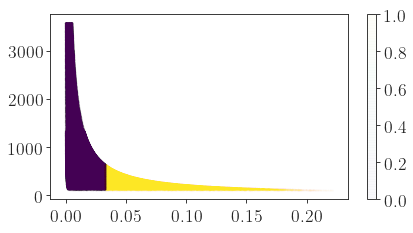

In [76]:
c=plt.scatter(mus, ds, s=1., alpha=0.01,c=prob, cmap='viridis')
plt.colorbar(c)

In [105]:
4*3

12